In [ ]:

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, RandomFlip, RandomRotation, Resizing, Rescaling, BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/My Drive/uc_merced_land_use'

In [ ]:
BATCH_SIZE = 56
IMG_W = 256
IMG_H = 256
EPOCH = 27
CHANNEL = 3

INPUT_SHAPE = [BATCH_SIZE, IMG_W, IMG_H, CHANNEL]

In [ ]:
train_data = keras.utils.image_dataset_from_directory(data_path + '/images_train_test_val/train')
val_data = keras.utils.image_dataset_from_directory(data_path + '/images_train_test_val/validation')
test_data = keras.utils.image_dataset_from_directory(data_path + '/images_train_test_val/test')

Found 7370 files belonging to 21 classes.
Found 2100 files belonging to 21 classes.
Found 1050 files belonging to 21 classes.


In [ ]:
for batch_image, batch_label in train_data.take(1):
    print("Image batch shape:", batch_image.shape)
    print("Label batch shape:", batch_label.shape)
    break

print("Train data batches:", len(train_data))
print("Validation data batches:", len(val_data))
print("Test data batches:", len(test_data))

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Train data batches: 231
Validation data batches: 66
Test data batches: 33


In [ ]:
classes = train_data.class_names
n_classes = len(classes)
classes
#n_classes

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

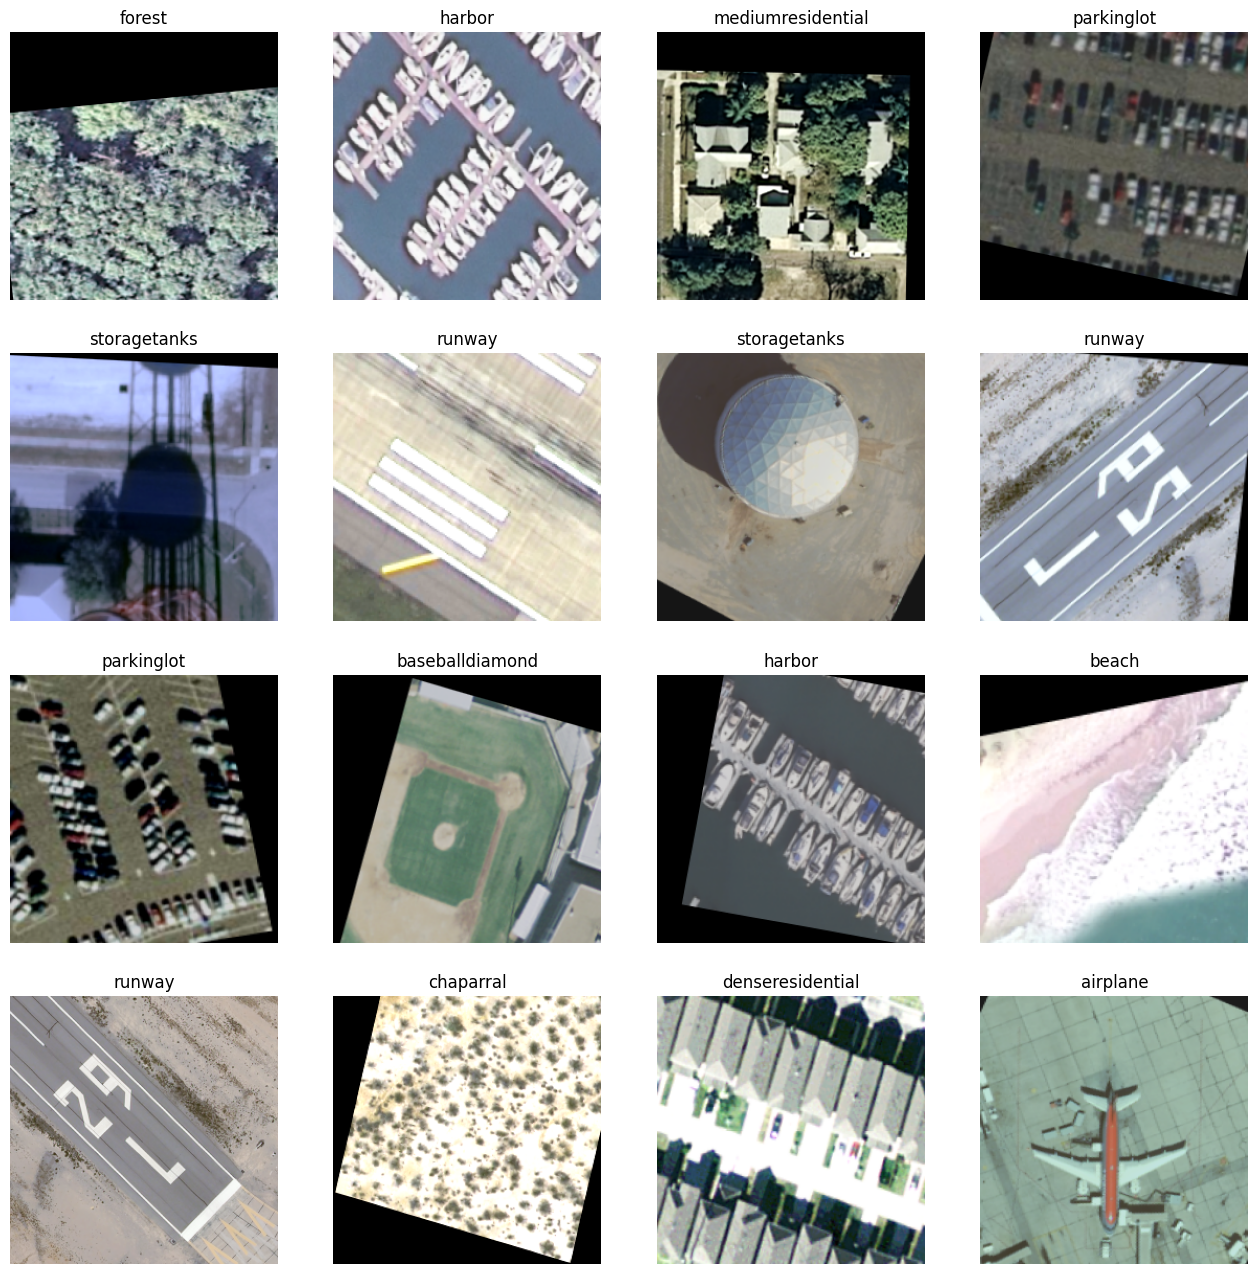

In [ ]:
for batch_image, batch_label in train_data.take(1):
    plt.figure(figsize=(16, 16))
    for i in range(16):
        img = batch_image[i].numpy().astype("uint8")
        lbl = classes[batch_label[i].numpy()]
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.title(lbl)
        plt.axis("off")

In [ ]:
augmentation = Sequential([
    Resizing(IMG_W, IMG_H),
    Rescaling(1.0/255),
    RandomFlip(mode="horizontal_and_vertical"),
    RandomRotation(0.1),
])

In [ ]:
from keras.layers import Dropout
from tensorflow.keras.regularizers import l2


model = keras.models.Sequential([
    augmentation,

    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(n_classes, activation='softmax')
])

model.build(input_shape=INPUT_SHAPE)


In [ ]:
model.compile(
optimizer= 'adam',
loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics= ['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True

In [ ]:
history = model.fit(train_data, epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1, validation_data=val_data)


Epoch 1/27
231/231 [==============================] - 48s 196ms/step - loss: 3.2342 - accuracy: 0.2012 - val_loss: 5.4052 - val_accuracy: 0.0505
Epoch 2/27
231/231 [==============================] - 45s 191ms/step - loss: 2.4997 - accuracy: 0.2939 - val_loss: 2.3282 - val_accuracy: 0.3281
Epoch 3/27
231/231 [==============================] - 45s 194ms/step - loss: 2.1950 - accuracy: 0.3738 - val_loss: 1.7538 - val_accuracy: 0.4862
Epoch 4/27
231/231 [==============================] - 45s 192ms/step - loss: 1.9623 - accuracy: 0.4327 - val_loss: 1.5845 - val_accuracy: 0.5452
Epoch 5/27
231/231 [==============================] - 45s 193ms/step - loss: 1.8164 - accuracy: 0.4757 - val_loss: 1.5904 - val_accuracy: 0.5343
Epoch 6/27
231/231 [==============================] - 45s 195ms/step - loss: 1.6710 - accuracy: 0.5058 - val_loss: 1.3369 - val_accuracy: 0.6157
Epoch 7/27
231/231 [==============================] - 45s 193ms/step - loss: 1.5974 - accuracy: 0.5396 - val_loss: 1.5416 - val_ac

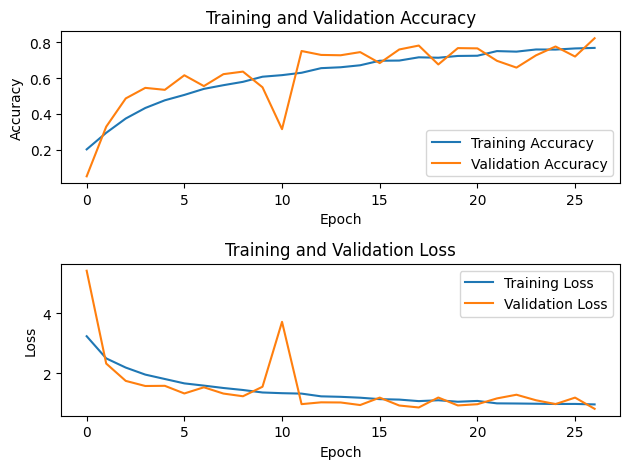

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

true_labels = []
all_pred_classes = []

for images, labels in test_data:
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)

    true_labels.extend(labels.numpy())
    all_pred_classes.extend(pred_classes)

1/1 [==============================] - 0s 190ms/step


In [ ]:
report = classification_report(true_labels, all_pred_classes, target_names = classes)
print("Classification Report:")
print(report)

Classification Report:
                   precision    recall  f1-score   support

     agricultural       0.84      0.98      0.91        50
         airplane       0.91      0.80      0.85        50
  baseballdiamond       0.85      0.68      0.76        50
            beach       0.68      0.94      0.79        50
        buildings       0.60      0.70      0.65        50
        chaparral       0.98      1.00      0.99        50
 denseresidential       0.69      0.40      0.51        50
           forest       0.89      0.96      0.92        50
          freeway       0.80      0.88      0.84        50
       golfcourse       0.59      0.82      0.68        50
           harbor       0.98      1.00      0.99        50
     intersection       0.85      0.80      0.82        50
mediumresidential       0.68      0.72      0.70        50
   mobilehomepark       0.80      0.94      0.86        50
         overpass       0.86      0.76      0.81        50
       parkinglot       1.00    

In [ ]:
def decode_labels(labels):
     return np.argmax(labels, axis = 1)


1/1 [==============================] - 0s 74ms/step


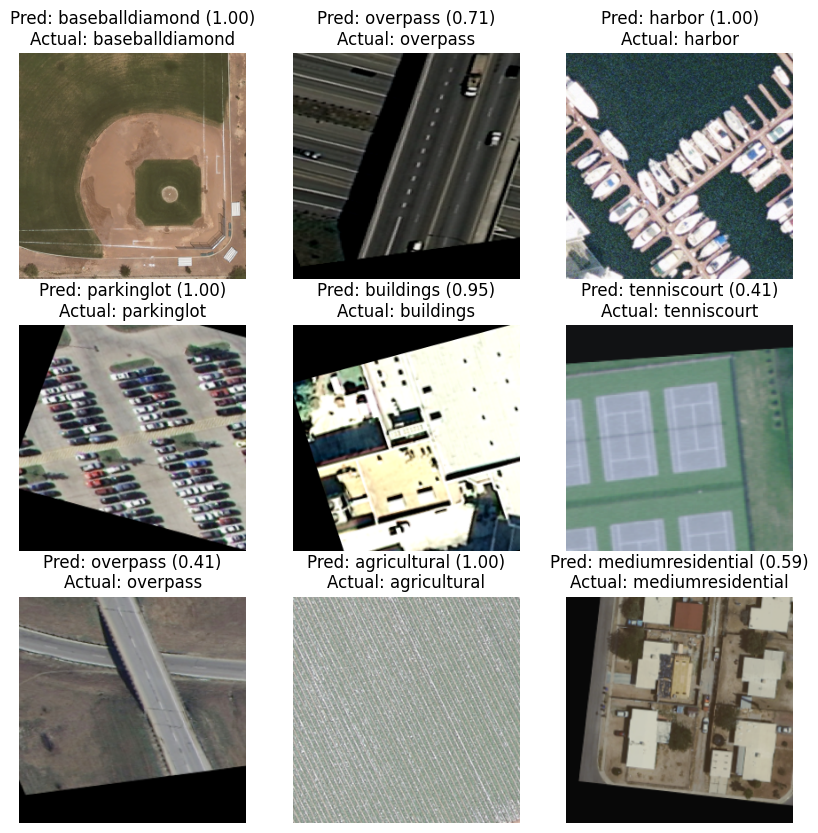

In [ ]:
for images, labels in test_data.take(1):
    predictions = model.predict(images)
    pred_classes = decode_labels(predictions)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_class = classes[pred_classes[i]]
        true_class = classes[labels[i].numpy()]
        prob = np.max(predictions[i])
        plt.title(f"Pred: {pred_class} ({prob:.2f})\nActual: {true_class}")
        plt.axis("off")
    plt.show()
